# 2 Layer Neural Network

## Imports

In [35]:
import os
import pandas as pd
import numpy as np

## Import data and create .csv

In [69]:
# Directory to MRI Images
base_dir = '/Users/benrandoing/Downloads/archive/GANAugmentedAD'
classes = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

if not os.path.exists('dataset.csv'):
    data = []

    for label, class_name in enumerate(classes):
        class_dir = os.path.join(base_dir, class_name)
        for image_name in os.listdir(class_dir):
            image_path = os.path.join(class_dir, image_name)
            data.append([image_path, label])

    df = pd.DataFrame(data, columns=['path', 'label'])
    df.to_csv('dataset.csv', index=False)

## Data Loading and Pre-Processing

In [3]:
%pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [70]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, random_split
from PIL import Image
import torch.optim
import cv2


class CustomDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.dataframe = pd.read_csv(csv_file)
        self.dataframe = self.dataframe.sample(frac=1).reset_index(drop=True)  # Shuffle the dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = self.dataframe.iloc[idx, 0]
        image = Image.open(img_name)
        image = np.array(image)
        if len(image.shape) < 3:
            image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        image = Image.fromarray(image)
        label = int(self.dataframe.iloc[idx, 1])

        if self.transform:
            image = self.transform(image)

        return image, label

# crop_size = 440

transform = transforms.Compose([
    # transforms.CenterCrop((240, crop_size)),
    transforms.Resize((224, 224)),  # Resize image to 224 X 224
    transforms.ToTensor(),
    # transforms.Lambda(lambda x: torch.rot90(x, k=1, dims=(-2, -1))),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    #transforms.Lambda(lambda x: x.view(-1))  # Flatten the image
])

# Load the entire dataset
dataset = CustomDataset(csv_file='dataset.csv', transform=transform)

# Split the dataset into train, validation, and test sets
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [29]:
print(f'Training Samples: {len(train_dataset)}')
print(f'Validation Samples: {len(val_dataset)}')
print(f'Test Samples: {len(test_dataset)}')

Training Samples: 24012
Validation Samples: 5145
Test Samples: 5147


In [19]:
print(train_dataset)

In [20]:
import matplotlib.pyplot as plt
#plt.plot(train_dataset[0][0])
#plt.show()

## Pytorch Logistic Regression Model

In [21]:
class FiveLayerNN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, hidden_dim3, hidden_dim4, output_dim):
        super(FiveLayerNN, self).__init__()
        self.fc1 = torch.nn.Linear(input_dim, hidden_dim1)
        self.fc2 = torch.nn.Linear(hidden_dim1, hidden_dim2)
        self.fc3 = torch.nn.Linear(hidden_dim2, hidden_dim3)
        self.fc4 = torch.nn.Linear(hidden_dim3, hidden_dim4)
        self.fc5 = torch.nn.Linear(hidden_dim4, output_dim)

    def forward(self, x):
        #x = x.view(-1, 224 * 224 * 3)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = self.fc5(x)
        return x

input_dim = 224 * 224 * 3  # Assuming the images are RGB
hidden_dim1 = 512
hidden_dim2 = 256
hidden_dim3 = 128
hidden_dim4 = 64
output_dim = 4  # Four classes

#model = FiveLayerNN(input_dim, hidden_dim1, hidden_dim2, hidden_dim3, hidden_dim4, output_dim)
import torchvision
from torchvision.models import resnet18, ResNet18_Weights
model = torchvision.models.resnet18(weights=ResNet18_Weights.DEFAULT)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

model.fc = torch.nn.Linear(model.fc.in_features, output_dim)


## Hyperparameters

In [22]:
learning_rate = 0.001
num_epochs = 20
batch_size = 64

## DataLoaders

In [71]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Loss and Optimizer

In [14]:
# Define the loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
#lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

## Training Loop

In [ ]:
# DO NOT RUN IF LOADING WEIGHTS

# Initialize lists to store metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0.0
    correct_train = 0
    total_train = 0

    i = 0
    for inputs, labels in train_loader:
        i = i + 1
        # print("Training continues..", total_train_loss, "current i = ", i)
        optimizer.zero_grad()
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    # Validation phase
    model.eval()
    total_val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

            # Calculate validation accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_accuracy = 100 * correct_val / total_val
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch}: Train Loss: {avg_train_loss}, Train Accuracy: {train_accuracy}%, Val Loss: {avg_val_loss}, Val Accuracy: {val_accuracy}%")

Training continues.. 175.3999701142311 current i =  366
Training continues.. 175.82154738903046 current i =  367
Training continues.. 176.05595360696316 current i =  368
Training continues.. 176.2083674520254 current i =  369
Training continues.. 176.5173833221197 current i =  370
Training continues.. 176.6523278951645 current i =  371
Training continues.. 176.87236173450947 current i =  372
Epoch 0: Train Loss: 0.4762436768781113, Train Accuracy: 79.41399024718345%, Val Loss: 0.7012588914483786, Val Accuracy: 77.00608200902492%
Training continues.. 0.0 current i =  1
Training continues.. 0.13410533964633942 current i =  2
Training continues.. 0.35636359453201294 current i =  3
Training continues.. 0.5289708971977234 current i =  4
Training continues.. 0.76946721971035 current i =  5
Training continues.. 0.9418478310108185 current i =  6
Training continues.. 1.1364059001207352 current i =  7
Training continues.. 1.5492983311414719 current i =  8
Training continues.. 1.6742920652031898 

KeyboardInterrupt: 

In [43]:
torch.save(model.state_dict(), 'model_state_dictGAN.pth')

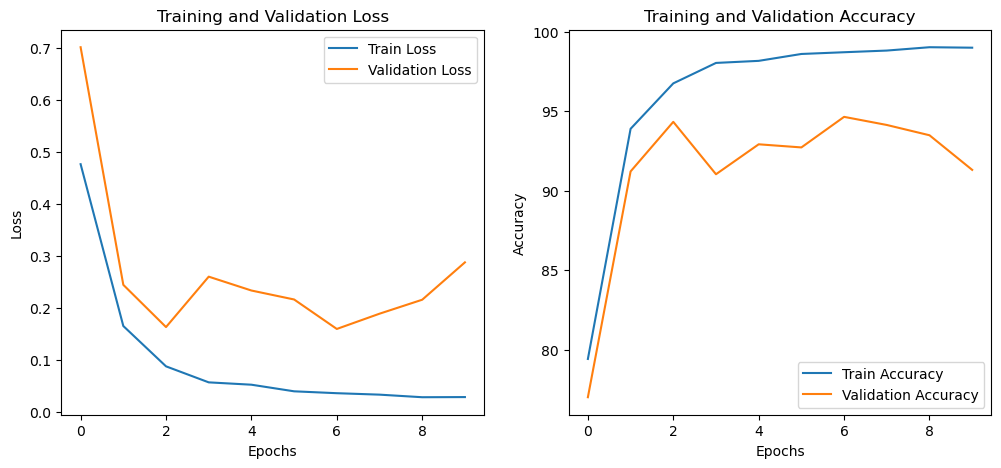

In [45]:
# Plotting
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('GAN_plot.png')

plt.show()

## Load Model Weights

In [67]:
model.load_state_dict(torch.load('resnet18_more_epochs_adam_model_weights.pth'))

<All keys matched successfully>

## Evaluation

In [68]:
# Validation loop
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for i, (inputs, labels) in enumerate(val_loader):
        print(i)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        validation_accuracy = 100 * correct / total
        local_acc = 100 * (predicted == labels).sum().item() / labels.size(0)
        print(f"Validation Accuracy: {validation_accuracy}% Batch Accuracy: "
              f"{local_acc}")

0
Validation Accuracy: 32.8125% Batch Accuracy: 32.8125
1
Validation Accuracy: 35.15625% Batch Accuracy: 37.5
2
Validation Accuracy: 37.5% Batch Accuracy: 42.1875
3
Validation Accuracy: 38.671875% Batch Accuracy: 42.1875


KeyboardInterrupt: 

## Test

In [10]:
# Testing loop
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f"Test Accuracy: {test_accuracy}%")

Test Accuracy: 90.68444793096685%


In [46]:
import torch
torch.save(model.state_dict(), 'model_state_dictGAN.pth')

### Saliency Plots

In [63]:
classes = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

def show_saliency():
    """
    Compute a class saliency map for a single DL batch using the model for images X and labels y command and parameters.
    """
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        model.eval()

        for name, param in model.named_parameters():
            print(name, param.size())

        # Set requires_grad=True for model parameters
        for param in model.parameters():
            param.requires_grad = True

        images.requires_grad_()
        outputs_saliency = model(images)

        score, predicted = torch.max(outputs_saliency, 1)
        print(score[-1].requires_grad)

        model.zero_grad()

        score = score.sum()  # Ensure score is a scalar for backward()

        score.backward()

        saliency = images.grad.abs()
        saliency = saliency.cpu().detach().numpy()  # Move tensor to CPU and convert to NumPy array
        images = images.cpu().detach().numpy()  # Move tensor to CPU and convert to NumPy array


#         N = images.shape[0]
        N = 5
        for i in range(N):
            plt.subplot(2, N, i + 1)
            plt.imshow(images[i].squeeze()[0], cmap='gray')
            plt.title(classes[labels[i].numpy()])
            plt.axis('off')
            plt.subplot(2, N, N + i + 1)
            plt.imshow(saliency[i].squeeze()[0], cmap=plt.cm.hot)
            plt.axis('off')
            plt.gcf().set_size_inches(12, 5)
        plt.savefig('saliencybw.png')
        plt.show()

        return

conv1.weight torch.Size([64, 3, 7, 7])
bn1.weight torch.Size([64])
bn1.bias torch.Size([64])
layer1.0.conv1.weight torch.Size([64, 64, 3, 3])
layer1.0.bn1.weight torch.Size([64])
layer1.0.bn1.bias torch.Size([64])
layer1.0.conv2.weight torch.Size([64, 64, 3, 3])
layer1.0.bn2.weight torch.Size([64])
layer1.0.bn2.bias torch.Size([64])
layer1.1.conv1.weight torch.Size([64, 64, 3, 3])
layer1.1.bn1.weight torch.Size([64])
layer1.1.bn1.bias torch.Size([64])
layer1.1.conv2.weight torch.Size([64, 64, 3, 3])
layer1.1.bn2.weight torch.Size([64])
layer1.1.bn2.bias torch.Size([64])
layer2.0.conv1.weight torch.Size([128, 64, 3, 3])
layer2.0.bn1.weight torch.Size([128])
layer2.0.bn1.bias torch.Size([128])
layer2.0.conv2.weight torch.Size([128, 128, 3, 3])
layer2.0.bn2.weight torch.Size([128])
layer2.0.bn2.bias torch.Size([128])
layer2.0.downsample.0.weight torch.Size([128, 64, 1, 1])
layer2.0.downsample.1.weight torch.Size([128])
layer2.0.downsample.1.bias torch.Size([128])
layer2.1.conv1.weight tor

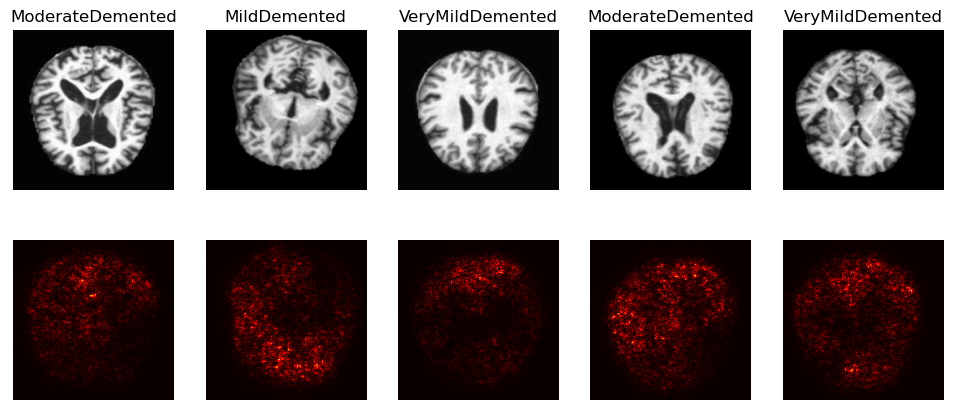

In [73]:
show_saliency()

# Gradient Ascent of Final Convolutional Layer in Model

In [49]:
# print(model)
print(model.layer1[1].conv2)

# for name, module in model.named_modules():
#     print(f"Layer: {name}")
#     for param_name, param in module.named_parameters(recurse=False):
#         print(f"\tParam: {param_name}, Shape: {param.shape}, Requires Grad: {param.requires_grad}")

Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


512
0


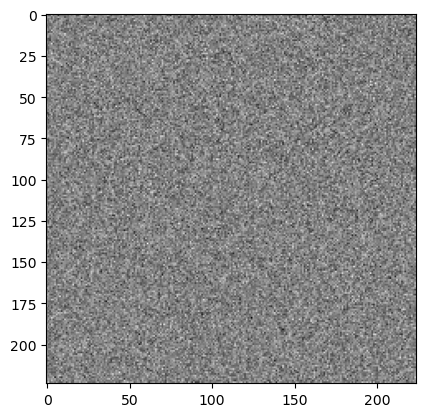

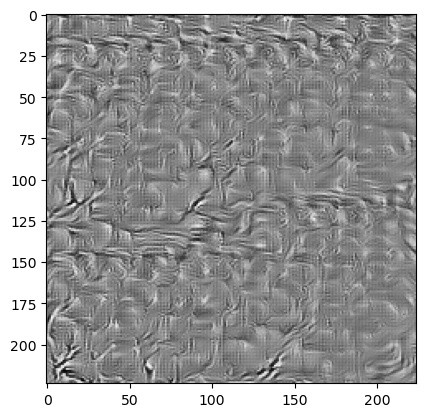

1


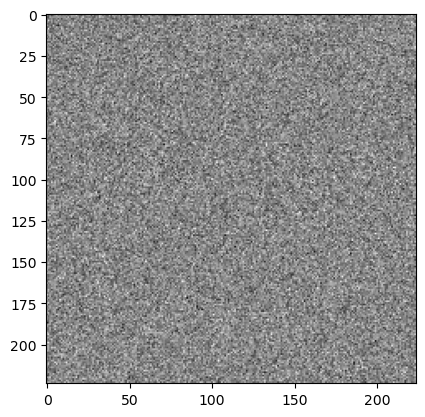

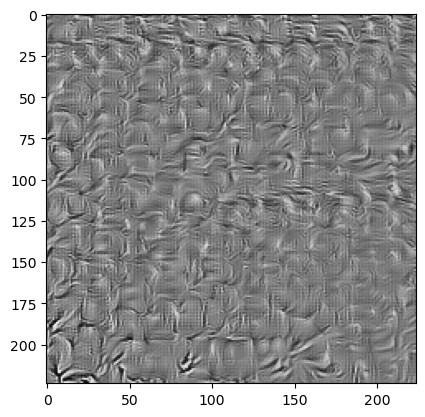

2


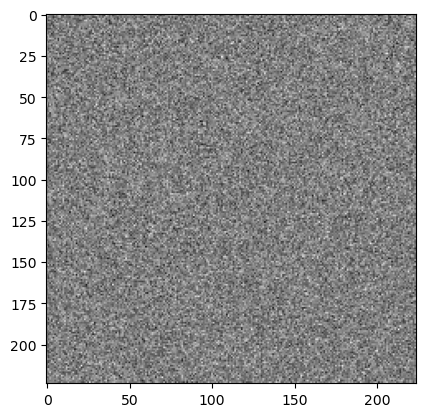

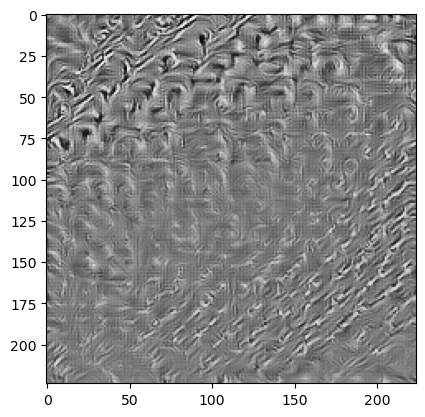

3


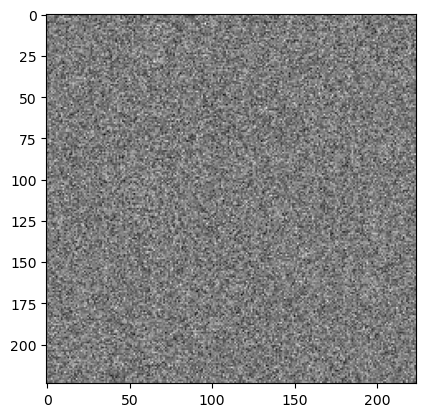

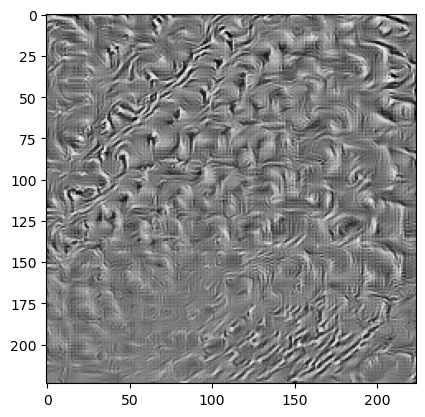

4


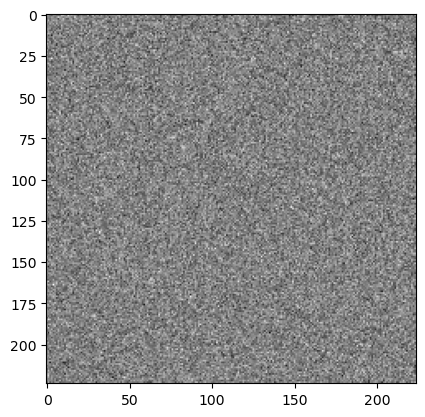

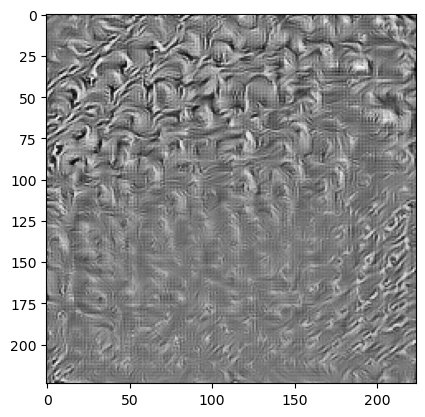

In [50]:
model.eval()  # Set the model to evaluation mode

# Select the target layer
target_layer = model.layer4

# Number of channels in the target layer
num_filters = target_layer[1].conv2.out_channels
print(num_filters)

# Forward hook to capture the activations of the target layer
activations = []
def forward_hook(module, input, output):
    activations.append(output)

target_layer.register_forward_hook(forward_hook)

num_iterations = 500
for filter_index in range(5):#range(num_filters):
    print(filter_index)
    # Initialize a random image
    input_image = torch.randn(1, 3, 224, 224, requires_grad=True)

    optimizer = torch.optim.Adam([input_image], lr=0.05)

    # Gradient ascent for the current filter
    for i in range(num_iterations):
        optimizer.zero_grad()
        output = model(input_image)

        # Loss is the mean activation of the current filter
        loss = -activations[-1][0, filter_index].mean()

        # Backward pass
        loss.backward()

        # Update the image
        optimizer.step()

        # Clear the activations
        activations = []

        if (i % (num_iterations - 1) == 0):
            plt.imshow(input_image.detach().numpy().squeeze().mean(axis=0),
                cmap='gray')
            plt.show()

# Guided Backprop (Similar to Saliency)

In [51]:
import torch.nn.functional as F

class GuidedReLU(torch.nn.Module):
    def forward(self, input):
        '''
        Function designed to only allow positive gradients in backprop
        '''
        positive_mask = (input > 0).type_as(input)
        output = F.relu(input)
        return output * positive_mask

def replace_relu_with_guidedrelu(model):
    for name, module in model.named_children():
        if isinstance(module, torch.nn.ReLU):
            setattr(model, name, GuidedReLU())
        else:
            replace_relu_with_guidedrelu(module)

In [52]:
def guided_backprop(model, images, target_class):
    replace_relu_with_guidedrelu(model)

    model.eval()

    images.requires_grad_()
    outputs = model(images)

    model.zero_grad()

    one_hot_output = torch.zeros_like(outputs)
    one_hot_output[:, target_class] = 1

    outputs.backward(gradient=one_hot_output)

    saliency = images.grad.abs()
    return saliency

In [53]:
import numpy as np

def overlay_saliency_map(original_image, saliency_map, alpha=0.5):
    saliency_map = (saliency_map - np.min(saliency_map)) / (np.max(saliency_map) - np.min(saliency_map))

    cmap = plt.get_cmap('hot')

    saliency_colored = cmap(saliency_map)

    # Overlay the saliency map on the original image
    plt.imshow(original_image, cmap='gray')
    plt.imshow(saliency_colored, alpha=alpha)  # alpha controls the transparency
    plt.axis('off')
    plt.show()

In [54]:
images, _ = next(iter(train_loader))  # Get a batch of images
target_class = 1  # Class you want to visualize
saliency = guided_backprop(model, images, target_class)

In [55]:
# #Visualize saliency map for the first image
# plt.imshow(saliency[0].squeeze().detach().numpy()[0], cmap=plt.cm.hot)
# plt.axis('off')
# plt.show()

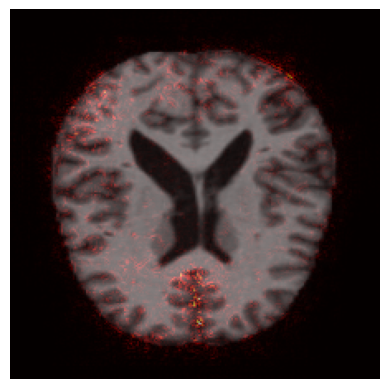

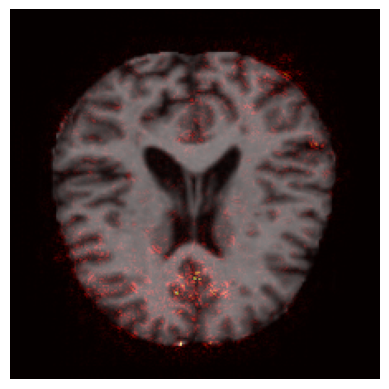

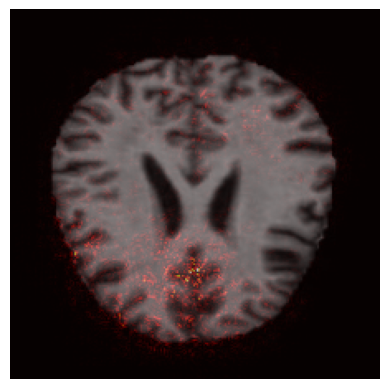

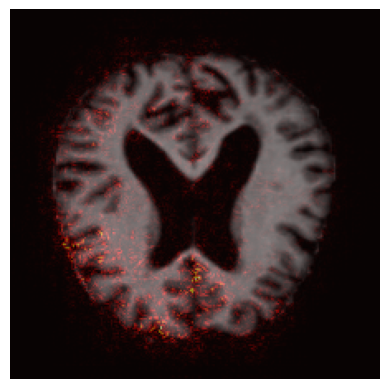

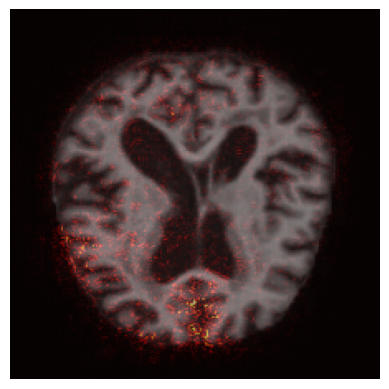

In [56]:
num_images = 5

for i in range(num_images):
    original_image = images[i].detach().numpy()[0]
    saliency_map = saliency[i].squeeze().detach().numpy()[0]
    overlay_saliency_map(original_image, saliency_map)

plt.show()